In [1]:
import torch
import open_clip
from PIL import Image

import lxt.functional as lf
from lxt.models.openclip import attnlrp
from zennit.composites import LayerMapComposite
import zennit.rules as z_rules
from zennit.image import imgify
import matplotlib.pyplot as plt

device = 'cuda'

# Load the model and the tokenizer
model, _, preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='laion2b_s34b_b88k')
model.eval()
model = model.to(device)

tokenizer = open_clip.get_tokenizer('ViT-g-14')

# Load an image and tokenize text
text = tokenizer(['a beautiful LRP heatmap', 'a dog', 'a cat']).to(device)
image = preprocess(Image.open('dog_and_cat.jpg')).unsqueeze(0).to(device)

# Trace the model for LRP with both image and text input
x = torch.randn(1, 3, 224, 224, device=device)  # Dummy input for attnlrp registration
traced = attnlrp.register(model, dummy_inputs={'image': x, 'text': text}, verbose=True)

# Register Gamma rules for Conv2D = 100 and Linear = 0.1
zennit_comp = LayerMapComposite([
    (torch.nn.Conv2d, z_rules.Gamma(100)),   # Gamma = 100 for Conv2D layers
    (torch.nn.Linear, z_rules.Gamma(0.1))    # Gamma = 0.1 for Linear layers
])

# Register the composite with the traced model
zennit_comp.register(traced)

# Perform forward & backward pass for LRP
y = traced(image.requires_grad_(True), text)
logits = lf.matmul(y[0], y[1].transpose(0, 1))

# Explain the dog class ("a dog")
image.grad = None
logits[0, 1].backward()

# Extract and normalize the heatmap
heatmap = image.grad[0].sum(0)
heatmap = heatmap / abs(heatmap).max()

# Apply Gaussian Blur to smoothen the heatmap (optional)
heatmap_np = heatmap.cpu().numpy()



c:\Users\Stern\clip_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Stern\clip_env\lib\site-packages\open_clip\factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

+-------------------------------------------------------------------------------------------------+---------------------------------------------------------------+------------+------------------+
| Parent Module                                                                                   | Function                                                      | Replaced   | LRP compatible   |
+=================================================================================================+===============================================================+============+==================+
| ('visual.conv1', <class 'torch.nn.modules.conv.Conv2d'>)                                        | -                                                             | -          |  ⁇               |
+-------------------------------------------------------------------------------------------------+---------------------------------------------------------------+------------+------------------+
| ('visual.patch_dro

NameError: name 'cv2' is not defined

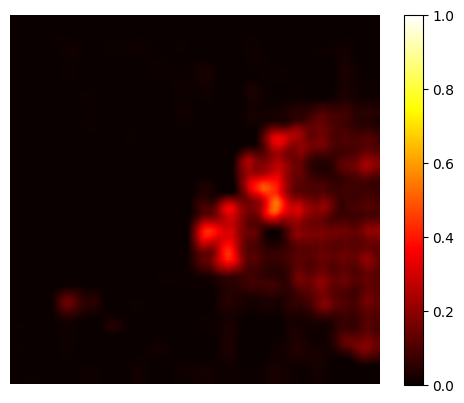

In [3]:
import cv2
heatmap_np = cv2.GaussianBlur(heatmap_np, (11, 11), sigmaX=5)

# Display the heatmap
plt.imshow(heatmap_np, cmap='hot', vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.show()

# Cleanup: Remove the registered Zennit composite after use
zennit_comp.remove()

In [7]:
import numpy as np
np.save('heatmap_all_layers.npy', heatmap_np)  # Save the heatmap as a .npy file for later use